<a href="https://colab.research.google.com/github/siting1206/2022_AIcup_NLP/blob/main/bert_CoLA_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation & Import Package

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Download the CoLA Dataset


In [3]:
!pip install git+https://github.com/Adapter-Hub/adapter-transformers.git
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Adapter-Hub/adapter-transformers.git to /tmp/pip-req-build-dr_n19yr
  Running command git clone -q https://github.com/Adapter-Hub/adapter-transformers.git /tmp/pip-req-build-dr_n19yr
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 182 kB 37.4 MB/s 
     |████████████████████████████████| 7.6 MB 64.8 MB/s 
  Created wheel for adapter-transformers: filename=adapter_transformers-3.2.0a0-py3-none-any.whl size=5601770 sha256=eb7a6f3ed2c5acb76c41143877274ef64d14cc5064b0ca4d93bbb6861f9fa725
  Stored in directory: /tmp/pip-ephem-wheel-cache-of_i0kju/wheels/ae/d3/bf/2cda8a83068958276e50c60058e87223acd5a9df015f04a65a
Successfully built adapter-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import wget
import os

print('Downloading dataset...')

# 資料集的下載連結
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# 如本地沒有，則下載資料集 
if not os.path.exists('/content/drive/MyDrive/NLP_final_project/cola_public_1.1.zip'):
    wget.download(url, '/content/drive/MyDrive/NLP_final_project/cola_public_1.1.zip')

In [5]:
# 如果沒解壓過，則解壓zip包
if not os.path.exists('/content/drive/MyDrive/NLP_final_project/cola_public/'):
    !unzip /content/drive/MyDrive/NLP_final_project/cola_public_1.1.zip

In [6]:
import pandas as pd

# 載入資料集到 pandas 的 dataframe 中
df = pd.read_csv("/content/drive/MyDrive/NLP_final_project/cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# 列印資料集的記錄數
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# 隨機預覽10筆資料 主要看sentence, label(0-語法不可接受, 1-語法可接受)
df.sample(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
5033,ks08,1,NaN,Which piano is this sonata easy to play on?
7766,ad03,1,NaN,Who did Athena introduce to whom?
5067,ks08,0,*,I owe that the jury acquitted me to you.
5714,c_13,1,NaN,The very young child walked from school to the...
2085,rhl07,1,NaN,"Sarah promised her old car to Catherine, but t..."
1120,r-67,1,NaN,They dismissed as too costly the proposal for ...
1297,r-67,0,*,Which quonset hut does the boy work in a skysc...
2202,l-93,1,NaN,Jill dressed hurriedly.
7783,ad03,1,NaN,I asked who Medea gave what?
7491,sks13,0,*,Mary sent.


In [7]:
# 隨機抽樣五筆語法上不可接受的資料
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

,sentence,label
493,"Bill seems to be obnoxious, but I don't think ...",0
1729,"Sally is tall, and may be, and Sheila is short...",0
869,"Mary claimed that eating cabbage, Holly started.",0
4829,Karen asked where for Jerry to put the chairs.,0
1398,Did you notice of which difficulties she made ...,0


In [8]:
# 構建 sentences 和 labels 列表
sentences = df.sentence.values
labels = df.label.values

## Tokenizer

In [9]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('gchhablani/bert-base-cased-finetuned-cola', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/320 [00:00<?, ?B/s]

In [10]:
print(' Original: ', sentences[0])

print('Tokenized: ', tokenizer.tokenize(sentences[0]))

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [1412, 2053, 1281, 112, 189, 4417, 1142, 3622, 117, 1519, 2041, 1103, 1397, 1141, 1195, 17794, 119]


In [11]:
max_len = 0
for sent in sentences:

    # 將文字分詞，並新增 `[CLS]` 和 `[SEP]` 符號
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  47


In [12]:
# 將資料集分完詞後儲存到列表中
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
        sent,              # 輸入文字
        add_special_tokens = True,   # 新增 '[CLS]' 和 '[SEP]'
        max_length = 64,        # 填充 & 截斷長度
        pad_to_max_length = True,
        return_attention_mask = True, # 返回 attn. masks.
        return_tensors = 'pt',     # 返回 pytorch tensors 格式的資料
    )
    
    # 將編碼後的文字加入到列表  
    input_ids.append(encoded_dict['input_ids'])
    
    # 將文字的 attention mask 也加入到 attention_masks 列表
    attention_masks.append(encoded_dict['attention_mask'])

# 將列表轉換為 tensor
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# 輸出第 1 行文字的原始和編碼後的資訊
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: tensor([  101,  1412,  2053,  1281,   112,   189,  4417,  1142,  3622,   117,
         1519,  2041,  1103,  1397,  1141,  1195, 17794,   119,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


### 將 90% 的資料集作為訓練集，剩下的 10% 作為驗證集

In [13]:
from torch.utils.data import TensorDataset, random_split

# 將輸入資料合併為 TensorDataset 物件
dataset = TensorDataset(input_ids, attention_masks, labels)

# 計算訓練集和驗證集大小
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# 按照資料大小隨機拆分訓練集和測試集
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


In [14]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# 在 fine-tune 的訓練中，BERT 建議的小批量為 16 或 32
batch_size = 32

# 為訓練和驗證集建立 Dataloader，對訓練樣本隨機洗牌
train_dataloader = DataLoader(
            train_dataset,  # 訓練樣本
            sampler = RandomSampler(train_dataset), # 隨機小批量
            batch_size = batch_size # 以小批量進行訓練
        )

# 驗證集不需要隨機化，這裡順序讀取就好
validation_dataloader = DataLoader(
            val_dataset, # 驗證樣本
            sampler = SequentialSampler(val_dataset), # 順序選取小批量
            batch_size = batch_size 
        )

## Model

In [21]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers.adapters import LoRAConfig

# 載入 BertForSequenceClassification, 預訓練 BERT 模型 + 頂層的線性分類層 
model = BertForSequenceClassification.from_pretrained(
    "gchhablani/bert-base-cased-finetuned-cola", # 小寫的 12 層預訓練模型
    num_labels = 2, # 分類數 --2 表示二分類
                    # 你可以改變這個數字，用於多分類任務  
    output_attentions = False, # 模型是否返回 attentions weights.
    output_hidden_states = False, # 模型是否返回所有隱層狀態.
    return_dict=False
)


# 在 gpu 中執行該模型
model.cuda()

BertForSequenceClassification(
  (shared_parameters): ModuleDict()
  (bert): BertModel(
    (shared_parameters): ModuleDict()
    (invertible_adapters): ModuleDict()
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(
                in_features=768, out_features=768, bias=True
                (loras): ModuleDict()
              )
              (key): Linear(
                in_features=768, out_features=768, bias=True
                (loras): ModuleDict()
              )
              (value): Linear(
                in_features=768, out_

In [22]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [49]:
from transformers import get_linear_schedule_with_warmup

# 訓練 epochs。 BERT 作者建議在 2 和 4 之間，設大了容易過擬合 
epochs = 4

# 總訓練樣本數
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [50]:
import numpy as np

# 根據預測結果和標籤資料來計算準確率
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [51]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # 四捨五入到最近的秒
    elapsed_rounded = int(round((elapsed)))
    
    # 格式化為 hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [52]:
import random
import numpy as np

# 設定隨機種子值，以確保輸出是確定的
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 儲存訓練和評估的 loss、準確率、訓練時長等統計指標, 
training_stats = []

# 統計整個訓練時長
total_t0 = time.time()

for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 統計單次 epoch 的訓練時間
    t0 = time.time()

    total_train_loss = 0

    # 將模型設定為訓練模式。
    # dropout、batchnorm 層在訓練和測試模式下的表現是不同的 (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # 訓練集小批量迭代
    for step, batch in enumerate(train_dataloader):

        # 每經過40次迭代，就輸出進度資訊
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 準備輸入資料，並將其拷貝到 gpu 中
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 每次計算梯度前，都需要將梯度清 0，因為 pytorch 的梯度是累加的
        model.zero_grad()        

        # 該函式會根據不同的引數，會返回不同的值。 本例中, 會返回 loss 和 logits -- 模型的預測結果
        loss, logits = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)

        # 累加 loss
        total_train_loss += loss.item()

        # 反向傳播
        loss.backward()

        # 梯度裁剪，避免出現梯度爆炸情況
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 更新引數
        optimizer.step()

        # 更新學習率
        scheduler.step()

    # 平均訓練誤差
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # 單次 epoch 的訓練時長
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # 完成一次 epoch 訓練後，就對該模型的效能進行驗證

    print("")
    print("Running Validation...")

    t0 = time.time()

    # 設定模型為評估模式
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # 將輸入資料載入到 gpu 中
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # 評估的時候不需要更新引數、計算梯度
        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # 累加 loss
        total_eval_loss += loss.item()

        # 將預測結果和 labels 載入到 cpu 中計算
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # 計算準確率
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # 列印本次 epoch 的準確率
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # 統計本次 epoch 的 loss
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # 統計本次評估的時長
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # 記錄本次 epoch 的所有統計資訊
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:14.
  Batch    80  of    241.    Elapsed: 0:00:29.
  Batch   120  of    241.    Elapsed: 0:00:42.
  Batch   160  of    241.    Elapsed: 0:00:56.
  Batch   200  of    241.    Elapsed: 0:01:09.
  Batch   240  of    241.    Elapsed: 0:01:23.

  Average training loss: 0.01
  Training epcoh took: 0:01:23

Running Validation...
  Accuracy: 0.91
  Validation Loss: 0.56
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:14.
  Batch    80  of    241.    Elapsed: 0:00:28.
  Batch   120  of    241.    Elapsed: 0:00:41.
  Batch   160  of    241.    Elapsed: 0:00:55.
  Batch   200  of    241.    Elapsed: 0:01:09.
  Batch   240  of    241.    Elapsed: 0:01:22.

  Average training loss: 0.02
  Training epcoh took: 0:01:22

Running Validation...
  Accuracy: 0.92
  Validation Loss: 0.55
  Validation took: 0:00:03

======== Epoch 3 / 4 ========
Training...
 

In [53]:
import pandas as pd

# 保留 2 位小數
pd.set_option('precision', 2)

# 載入訓練統計到 DataFrame 中
df_stats = pd.DataFrame(data=training_stats)

# 使用 epoch 值作為每行的索引
df_stats = df_stats.set_index('epoch')

# 展示表格資料
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.19e-02,0.56,0.91,0:01:23,0:00:03
2,1.76e-02,0.55,0.92,0:01:22,0:00:03
3,2.20e-02,0.56,0.91,0:01:22,0:00:03
4,8.40e-03,0.57,0.91,0:01:22,0:00:03


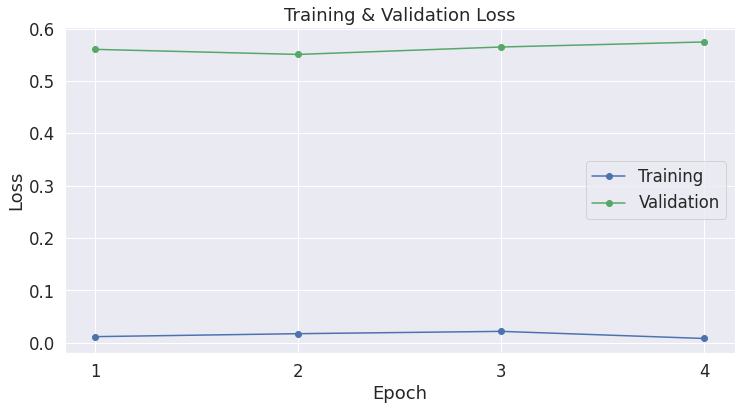

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# 繪圖風格設定
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# 繪製學習曲線
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## Test

In [55]:
import pandas as pd

# 載入資料集
df = pd.read_csv("/content/drive/MyDrive/NLP_final_project/cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# 列印資料集大小
print('Number of test sentences: {:,}\n'.format(df.shape[0]))
# 將資料集轉換為列表
sentences = df.sentence.values
labels = df.label.values

# 分詞、填充或截斷
input_ids = []
attention_masks = []
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
         sent,                      
         add_special_tokens = True, 
         max_length = 64,           
         pad_to_max_length = True,
         return_attention_mask = True,   
         return_tensors = 'pt',     
         )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

batch_size = 32  

# 準備好資料集
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [56]:
# 預測測試集

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

model.eval()

# Tracking variables 
predictions , true_labels = [], []

# 預測
for batch in prediction_dataloader:
  # 將資料載入到 gpu 中
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  
  # 不需要計算梯度
  with torch.no_grad():
      # 前向傳播，獲取預測結果
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # 將結果載入到cpu
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # 儲存預測結果和labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('DONE.')

Predicting labels for 516 test sentences...
DONE.


In [57]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [58]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# 計算每個 batch 的 MCC
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # 計算該 batch 的 MCC  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


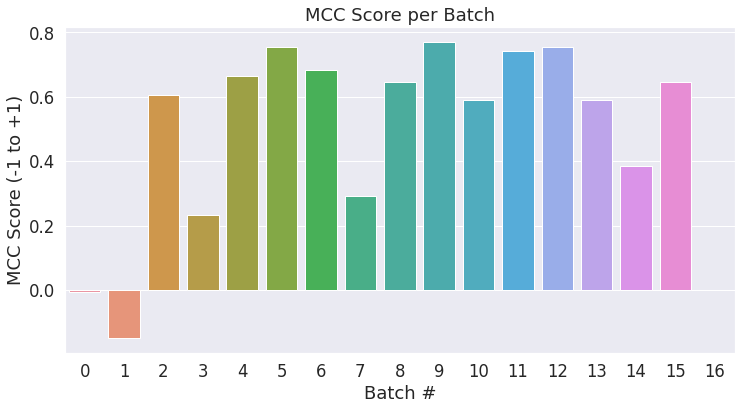

In [59]:
# 建立柱狀圖來顯示每個 batch 的 MCC 分數
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [60]:
# 合併所有 batch 的預測結果
flat_predictions = np.concatenate(predictions, axis=0)

# 取每個樣本的最大值作為預測值
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# 合併所有的 labels
flat_true_labels = np.concatenate(true_labels, axis=0)

# 計算 MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.540
